# Boltzmann Wealth Model

Build a very primitive Boltzmann wealth model felt a good place to start.

In [66]:
from mesa.model import Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import seaborn as sns

from src.nvx_sim.economy.agents import WealthAgent

In [67]:
class SimpleWealthAgent(WealthAgent):
    """
    A simple agent which gives their money away to nearby agents at random.
    """
    def __init__(self, model, initial_wealth = 1, give_wealth_chance = 0.5):
        super().__init__(model, initial_wealth)
        self.give_wealth_chance = give_wealth_chance
    
    def step(self):
        self.move()
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))
        
        if len(cellmates) > 0 and self.wealth > 0 and self.random.random() <= self.give_wealth_chance:
            target = self.random.choice(cellmates)
            self.give_wealth(1, target)

In [68]:
class BoltzmannWealthModel(Model):
    """
    A simple economic model where agents exchange currency at random.
    """
    
    def __init__(self, n=100, width=10, height=10, seed=None):
        super().__init__(seed=seed)
        
        self.num_agents = n
        self.grid = MultiGrid(width, height, torus=True)
        self.static = 1
        
        self.datacollector = DataCollector(
            agent_reporters={"wealth": "wealth"},
            model_reporters={"static": "static"},
        )
        
        for _ in range(self.num_agents):
            agent = SimpleWealthAgent(self, initial_wealth=1, give_wealth_chance=0.5)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))
        
        self.datacollector.collect(self)
        
    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

In [69]:
model = BoltzmannWealthModel(50, 10, 10)
for i in range(200):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()


In [70]:
agent_data_last_step = agent_data[agent_data.index.get_level_values('Step').isin([200])]

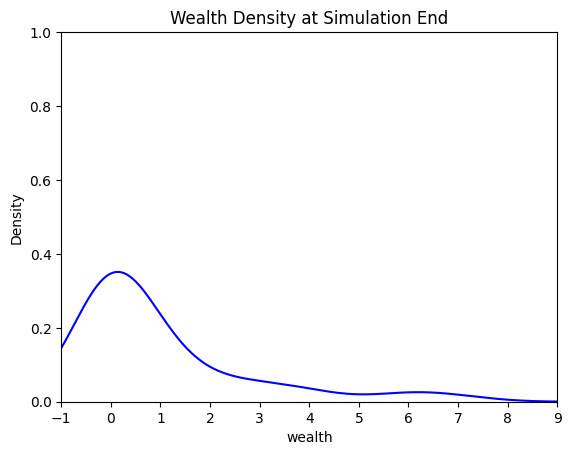

In [76]:
# Density plot
plt.figure()
sns.kdeplot(agent_data_last_step['wealth'], color='b')
plt.xlim(-1, 9)
plt.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title(f'Wealth Density at Simulation End')
plt.show()
plt.close()

In [73]:
# Create a gif of the wealth density among agents over time
SHOULD_CREATE_GIF = True

if SHOULD_CREATE_GIF:
    import imageio
    import os, os.path
    
    if os.path.exists("e01_density.gif"):
        os.remove("e01_density.gif")
    
    filenames = []
    for step in agent_data.index.get_level_values('Step').unique():
        if step == 0:
            continue
        plt.figure()
        sns.kdeplot(
            agent_data[agent_data.index.get_level_values('Step').isin([step])]['wealth'], 
            color='b',
        )
        plt.xlim(-1, 9)
        plt.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        plt.ylim(0, 1)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.title(f'Agent Density at Step {step}')
        filename = f"e01_frame_{step:03d}.png"
        plt.savefig(filename)
        filenames.append(filename)
        plt.close()
        
    with imageio.get_writer("e01_density.gif", mode="I", fps=10) as writer:
        for filename in filenames:
            im = imageio.v2.imread(filename)
            writer.append_data(im)
            
    for filename in filenames:
        os.remove(filename)

![Animated Density Graph](e01_density.gif)